# Задача бинарной классификации (Телеком):

- «1» - абонент является водителем (относится к сегменту водителей),
- «0» - абонент не является водителем (не относится к сегменту водителей).

Файлы tabular_data.csv и hashed_feature.csv ̶ здесь описательные характеристики по 5106 абонентам ( «ID» - это идентификатор абонента).
- Файл train.csv ̶ это данные по целевой метке (принадлежность абонента к сегменту водителей).
- Файл test.csv ̶ это список абонентов, для которых необходимо сделать прогноз, по которому мы и будем оценивать качество - модели.

Файл tabular_data.csv содержит числовые данные по активности абонентов за 12 периодов.
    - period - номер периода (периодs последовательные, 1 - новейший)
    - id - идентификатор абонента
    - feature_0 - feature_49 - данные по активности абонента в соответствующий период.

Файл hashed_feature.csv - здесь набор захешированых значений одной категориальной переменной для абонента.
    - id - идентификатор абонента
    - feature_50 - хэш от значения категориальной переменной.


Нужно построить модель на абонентах, целевая метка по которым содержится в файле train.csv. Для этого вам необходимо использовать данные из файлов tabular_data.csv и hashed_feature.csv. 
Обратите внимание, что необходимо спрогнозировать факт отношение к сегменту водителей, без привязки к периоду.

Цель в ROC-AUC 90%+

In [1508]:
import pandas as pd
import numpy as np
import math

from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from catboost import Pool, cv
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [1509]:
tabular_data = pd.read_csv('C:/project/files/my_projects/Telecom/tabular_data.csv')
hashed_feature = pd.read_csv('C:/project/files/my_projects/Telecom/hashed_feature.csv')
train = pd.read_csv('C:/project/files/my_projects/Telecom/train.csv')
test = pd.read_csv('C:/project/files/my_projects/Telecom/test.csv')

## Предварительный анализ данных

In [1510]:
train = train.set_index('id') #Series with Target
test = test.set_index('id')

In [1511]:
train.value_counts() #normalize=True

target
0         3009
1         1075
dtype: int64

In [1512]:
len(train)+len(test)

5106

In [1513]:
tabular_data[tabular_data['id']==3]

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
36,3,1,110.0,33.50,0.008239,266.829103,127.92,0.0,0.6955,234.57,...,0.22,0,0.005484,1.0,3.19,1.0,0.679096,153.0,93.30,9.0
37,3,2,110.0,75.94,NaN,3747.802363,92.25,0.0,NaN,195.98,...,1.82,0,0.071799,0.0,75.94,1.0,0.633550,120.0,68.18,9.0
38,3,3,110.0,78.06,NaN,532.755571,6.67,0.0,NaN,62.50,...,0.00,0,0.414138,1.0,75.00,1.0,0.758731,45.0,4.47,2.0
39,3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,3,7,NaN,NaN,5.170391,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1514]:
tabular_data['id'].nunique()

5106

### Посмотрим подробнее на 'feature_25':

In [1515]:
tabular_data['feature_25'].value_counts() # всего 8 уникальных значений

f9ae10397ed62e79c644d06842bbcd92963a5927    37061
b204e1e3743cc314841070435211e25f4602b9fd    13279
aa2c96dacf00c451ef465f6115a45a20bccf1256     5105
11e623a37e87cf7995c466723ec99688d55cae8c     4107
390c481a740bb1c12c57f33dc5263ced2ab11796     1297
d458ece2abeae803254c5d442b2e2a80f58a4153      313
cf3cca1da7361bd988642600e76c4a3021be8ccf       80
cf7413906c99be47067cb3fb6299959857710d77       30
Name: feature_25, dtype: int64

In [1516]:
tabular_data.groupby('id')['feature_25'].nunique().value_counts() # абсолютное большинство
# за год имеет 1-2 различных значения этой фичи

1    3749
2    1141
3     189
4      24
5       3
Name: feature_25, dtype: int64

In [1517]:
print(tabular_data['feature_25'].str.len().mean())
# BTIH (BitTorrent InfoHash) используется в p2p сети BitTorrent. Хэш является строкой из 40 шестнадцатеричных чисел.
#The md5 hash function

40.0


In [1518]:
# будем в дальнейшем называть эту фичу 'Тариф', т.к. по описанию уж очень подходит. 
# но в целом это может быть все, что угодно
feature_25 = tabular_data[['id','feature_25']].copy()
feature_25['values']=1
feature_25_transformed = feature_25.pivot_table(index='id', columns='feature_25', values='values').fillna(0)

In [1519]:
feature_25_transformed.head(2)

feature_25,11e623a37e87cf7995c466723ec99688d55cae8c,390c481a740bb1c12c57f33dc5263ced2ab11796,aa2c96dacf00c451ef465f6115a45a20bccf1256,b204e1e3743cc314841070435211e25f4602b9fd,cf3cca1da7361bd988642600e76c4a3021be8ccf,cf7413906c99be47067cb3fb6299959857710d77,d458ece2abeae803254c5d442b2e2a80f58a4153,f9ae10397ed62e79c644d06842bbcd92963a5927
id,,,,,,,,
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [1520]:
feature_25_transformed_train_target=feature_25_transformed.loc[train.index].astype('str').join(train)

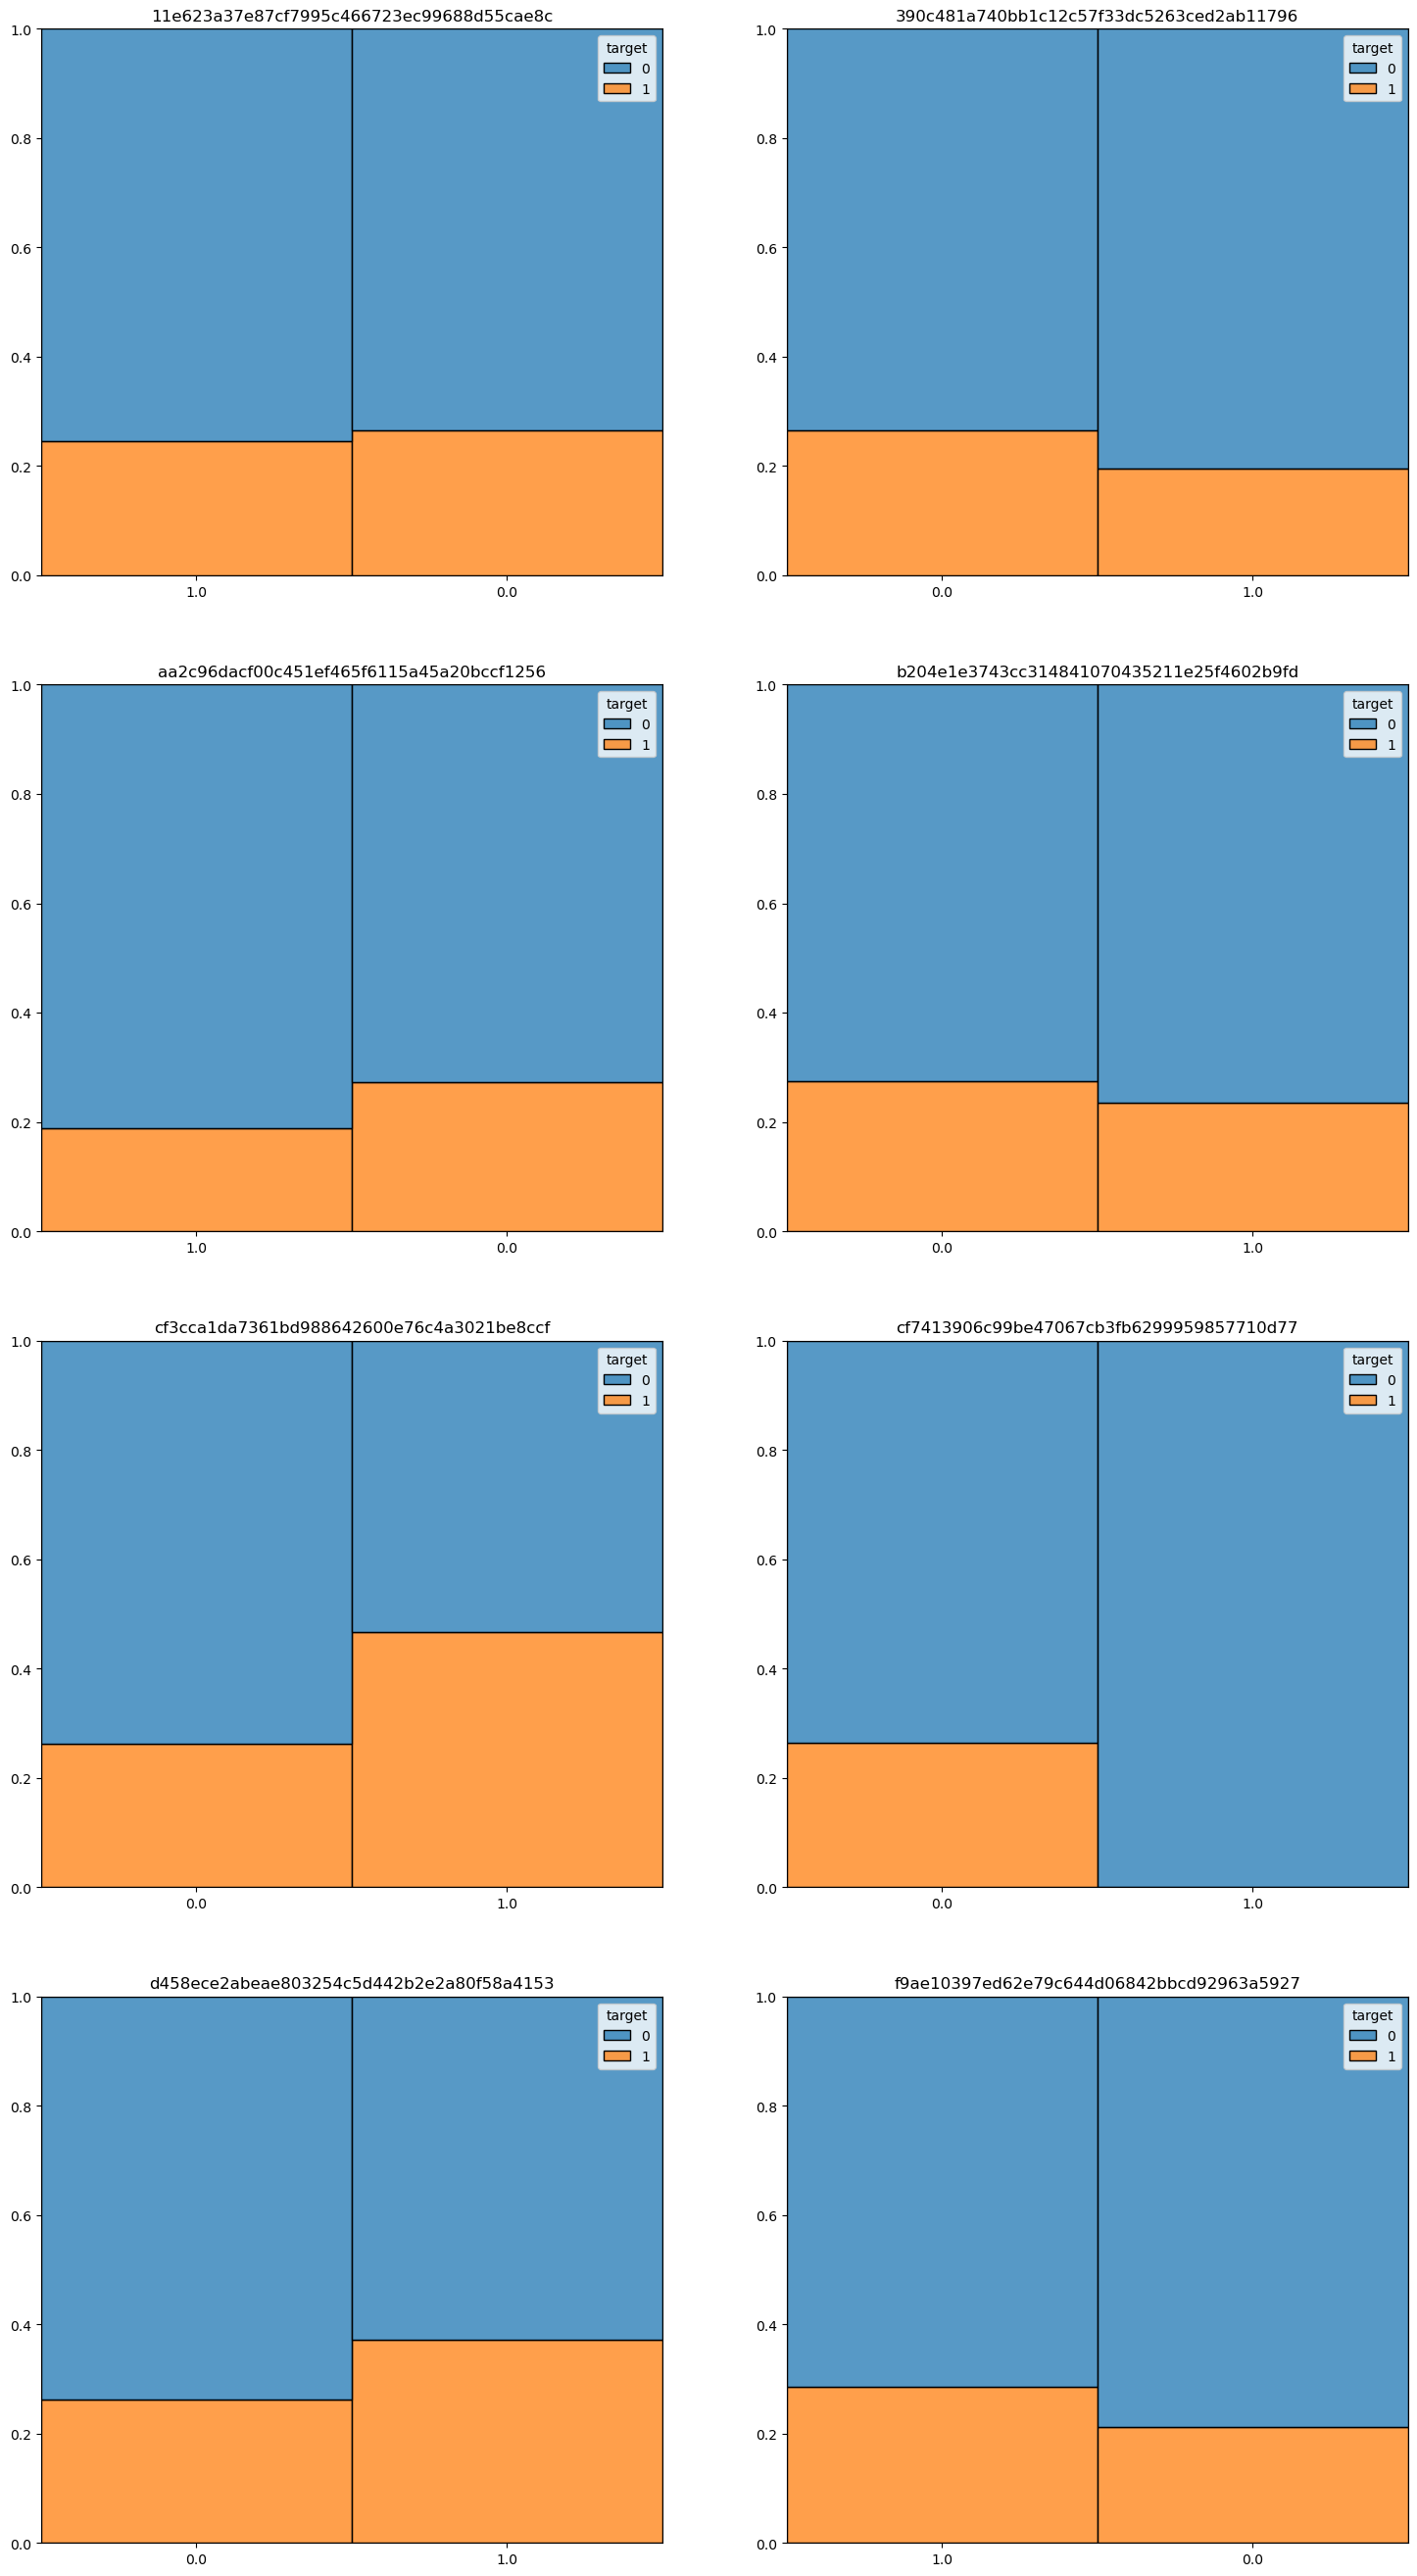

In [1521]:
ax = {}
fig = plt.figure(figsize=(18,42))
for i,j in enumerate(feature_25_transformed_train_target.columns[0:-1]):
    ax[i] = plt.subplot(math.ceil(len(feature_25_transformed_train_target.columns)/2),2,i+1)
    sns.histplot(data=feature_25_transformed_train_target, x=j, hue='target', multiple="fill", stat='probability')
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_title(j)

Можно отметить, что есть существенная разница между водителями и не водителями в тарифах 'cf3cca1da7361bd988642600e76c4a3021be8ccf' (80 записей) и 'cf7413906c99be47067cb3fb6299959857710d77' (30 записей). К сожалению, ими мало кто пользуется и это может быть просто совпадением. По массовым тарифам такой разницы не наблюдается.

### Датасет 'hashed_feature'

In [1522]:
hashed_feature.head(3)

,id,feature_50
0,0,7984b0a0e139cabadb5afc7756d473fb34d23819
1,0,47904b3331202e9881d003ff449c2eabfbc75460
2,0,a99c4b3af723874ddd85af322beea81b64437294


In [1523]:
hashed_feature['feature_50'].value_counts().head() #почти половина выборки имеет 
# хеш '7984b0a0e139cabadb5afc7756d473fb34d23819'

7984b0a0e139cabadb5afc7756d473fb34d23819    2531
732859d808df41a0c340c31a4ab55f6f8f77af42    1561
bc69c5b3e3892ae2d63629bc2c916cb67f17feaa     819
f4f7e30d6604756613a7c203ddd63cd93fe0f0b0     686
5a214d3b3a3f26cab544d931ad211881b1e3e4d2     621
Name: feature_50, dtype: int64

In [1524]:
# посчитаем самые популярные количества значений по пользователю:
hashed_feature_count = hashed_feature.groupby('id')['feature_50'].count()
hashed_feature_count.value_counts().head(5)

1    163
3    158
5    151
2    148
4    143
Name: feature_50, dtype: int64

<AxesSubplot:xlabel='feature_50', ylabel='Probability'>

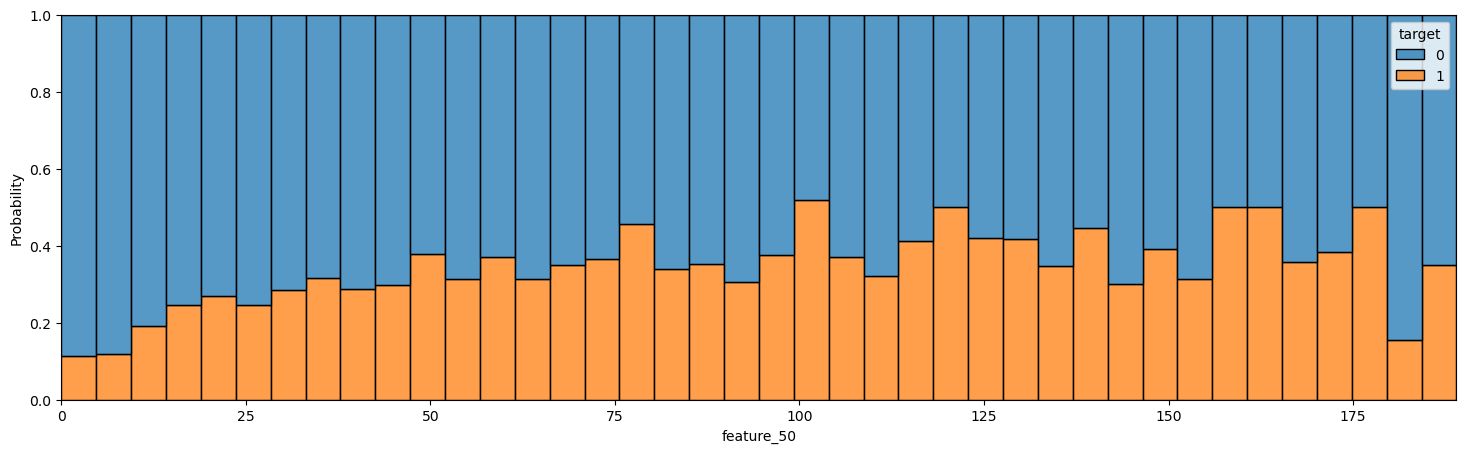

In [1525]:
temp = pd.concat([hashed_feature_count.loc[train.index], train], axis=1)[['feature_50', 'target']]
temp = temp[temp['feature_50']<temp['feature_50'].quantile(0.95)]

fig, ax = plt.subplots(1,1, figsize=(18, 5)) 
sns.histplot(data=temp, x='feature_50', hue="target", multiple="fill", stat='probability', bins=40)

Eсли количество записей по 'id' в 'hashed_feature' меньше 10, то вероятность, что это водитель очень небольшая. С ростом с 10 до 100 вероятность обнаружения водителя немного растет, затем держится примерно на одном уровне.

### Выводы:
    1. С числовыми признаками примерно все понятно. Надо посмотреть распределения и решить, каким образом преобразовать их,  чтобы не потерять распределение за 12 месяцев. Это может быть среднее, медиана, дисперсия, минимум, максимум
    2. 'feature_25' содержит всего 8 значений. При этом, у большинства клиентов, за год встречается 1-2 уникальных          значения. Это очень похоже на названия тарифа. 
    3. Для hashed_feature['feature_50'] у меня есть два варианта:
        3.1 Это очень похоже на список локаций(районов, базовых станций), по которые помещал клиент за какой-то период(пускай год). Можно отметить, что около половины клиентов не посещали больше 20 локаций в течение года. Предположим, что водитель в большинстве случаем преодолевает бОльшие дистанции, чем пешеход и имеет больше локаций. Возможно, должна быть сильная связь с 'feature_25': водители используют какой-то специальных тариф.
        3.2 Менее вероятная версия, что в 'feature_50' содержатся какие-то ключевые слова, вроде "автомобиль". И нам надо понять, какие слова(или их сочетания) относятся к таргету = 1.  Слабость этой версии в том, что непонятно, откуда берутся эти данные.

## Предобработка данных
### Feature_25 в 'tabular_data'
В задании написано, что актуальный период - 1. Если мы предполагаем, что это тариф, то нам нужен актуальный, из первого периода. Также можем вытащить параметр, сколько тарифов было в течение года.

In [1526]:
tarifs_nmb = tabular_data.rename(columns={'feature_25':'tarifs_nmb'}).groupby('id')['tarifs_nmb'].nunique()
# количество тарифов

In [1527]:
tarif = tabular_data.rename(columns={'feature_25':'tarif'})[tabular_data['period']==1][['id', 'tarif']].set_index('id')

In [1528]:
tarif = pd.get_dummies(tarif, drop_first=True)
tarif.head(3)
# OneHotEncoder лень использовать

,tarif_390c481a740bb1c12c57f33dc5263ced2ab11796,tarif_aa2c96dacf00c451ef465f6115a45a20bccf1256,tarif_b204e1e3743cc314841070435211e25f4602b9fd,tarif_cf3cca1da7361bd988642600e76c4a3021be8ccf,tarif_cf7413906c99be47067cb3fb6299959857710d77,tarif_d458ece2abeae803254c5d442b2e2a80f58a4153,tarif_f9ae10397ed62e79c644d06842bbcd92963a5927
id,,,,,,,
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0


### Числовые значения в 'tabular_data'

In [1529]:
tabular_data = tabular_data.drop(columns='feature_25')

In [1530]:
tabular_data.info()
# видно, что все признаки содержат Nan. Пока для нас это не очень страшно, т.к. данные будем агрегировать. 
# Надо проверить, все ли абоненты обслуживались 12 месяцев (Nan по всем фичам) и сформировать отдельный признак
# Отдельно вылезает 'feature_41', 'feature_38' со всеми заполненными значениями, это странно
# то же по feature_17 - и фича имеет равномерное!!! распределение (анализ чуть дальше)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61272 entries, 0 to 61271
Data columns (total 51 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          61272 non-null  int64  
 1   period      61272 non-null  int64  
 2   feature_0   58460 non-null  float64
 3   feature_1   58380 non-null  float64
 4   feature_2   57795 non-null  float64
 5   feature_3   58314 non-null  float64
 6   feature_4   58425 non-null  float64
 7   feature_5   58257 non-null  float64
 8   feature_6   57814 non-null  float64
 9   feature_7   58280 non-null  float64
 10  feature_8   58338 non-null  float64
 11  feature_9   58344 non-null  float64
 12  feature_10  58318 non-null  float64
 13  feature_11  58184 non-null  float64
 14  feature_12  57847 non-null  float64
 15  feature_13  57938 non-null  float64
 16  feature_14  58366 non-null  float64
 17  feature_15  58410 non-null  float64
 18  feature_16  58193 non-null  float64
 19  feature_17  61272 non-nul

In [1531]:
tabular_data['feature_41'].value_counts()
# 'feature_41' состоит из нулей, ее можно дропнуть

0    61272
Name: feature_41, dtype: int64

In [1532]:
tabular_data = tabular_data.drop(columns='feature_41')

In [1533]:
tabular_data['feature_38'].value_counts().head(3)

0.000000    58209
0.230400        1
0.580333        1
Name: feature_38, dtype: int64

In [1534]:
tabular_data[tabular_data['feature_38']!=0].groupby('id')['id'].count().value_counts() # думаю, что фичу можно оставить
# у нас есть 256 пользователей, у которых эта фича ненулевая

12    255
3       1
Name: id, dtype: int64

In [1535]:
# 'feature_17' интересна тем, что единственная имеет значения у всех записей.
# Находится в диапазоне 0-1
# Значения распределены равномерно, что не встречается для реальных данных
# Медиана/Среднее/Дисперсия по ней нам ничего не даст
# Очень похоже, что ее создали специально и либо она бесполезна, либо из нее можно создать очень сильную фичу
feature_17 = tabular_data[tabular_data['period']==12][['id','feature_17']].set_index('id')#.hist()
feature_17 = feature_17.loc[train.index].join(train)

<AxesSubplot:>

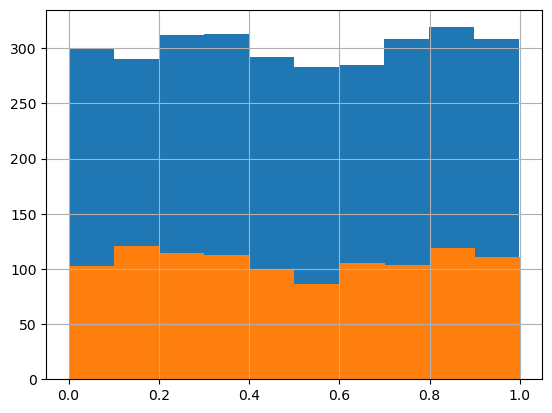

In [1536]:
feature_17[feature_17['target']==0]['feature_17'].hist()
feature_17[feature_17['target']==1]['feature_17'].hist()
# равномерное распределение

In [1537]:
# 4 - 9
# Чуть дольше будут представлены графики медиан по периодам относительно таргета. 
# У этой фичи наибольшая разница по таргетам наблюдается между 4м и 9м месяцем
feature_17_4 = tabular_data[tabular_data['period']==4][['id','feature_17']].set_index('id')
feature_17_9 = tabular_data[tabular_data['period']==9][['id','feature_17']].set_index('id')

feature_17_4_9 = feature_17_4-feature_17_9
feature_17_4_9_train = feature_17_4_9.loc[train.index].join(train)

<AxesSubplot:>

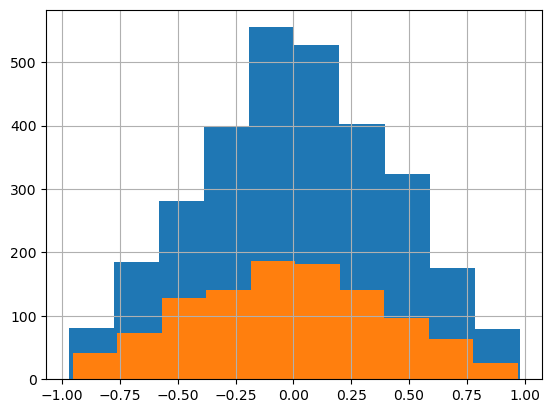

In [1538]:
# Как мы видим, в итоге получили два нормальных распределения
# Я рассчитывал, что одно будет смещено влево, а другое вправо, но к сожалению, этого не наблюдается
feature_17_4_9_train[feature_17_4_9_train['target']==0]['feature_17'].hist()
feature_17_4_9_train[feature_17_4_9_train['target']==1]['feature_17'].hist()

In [1539]:
#tabular_data = tabular_data.drop(columns=['feature_17','feature_38'] )
# 'feature_38' - в дисперсию, медиана не сработает, мало значений

Проанализируем распределение числовых значений по месяцам относительно таргета. Тут нам надо понять:
- Для разделения каких признаков по таргету хорошо работает мединана
- Среднее
- Дисперсия
- Что-то другое, вроде разных трендов

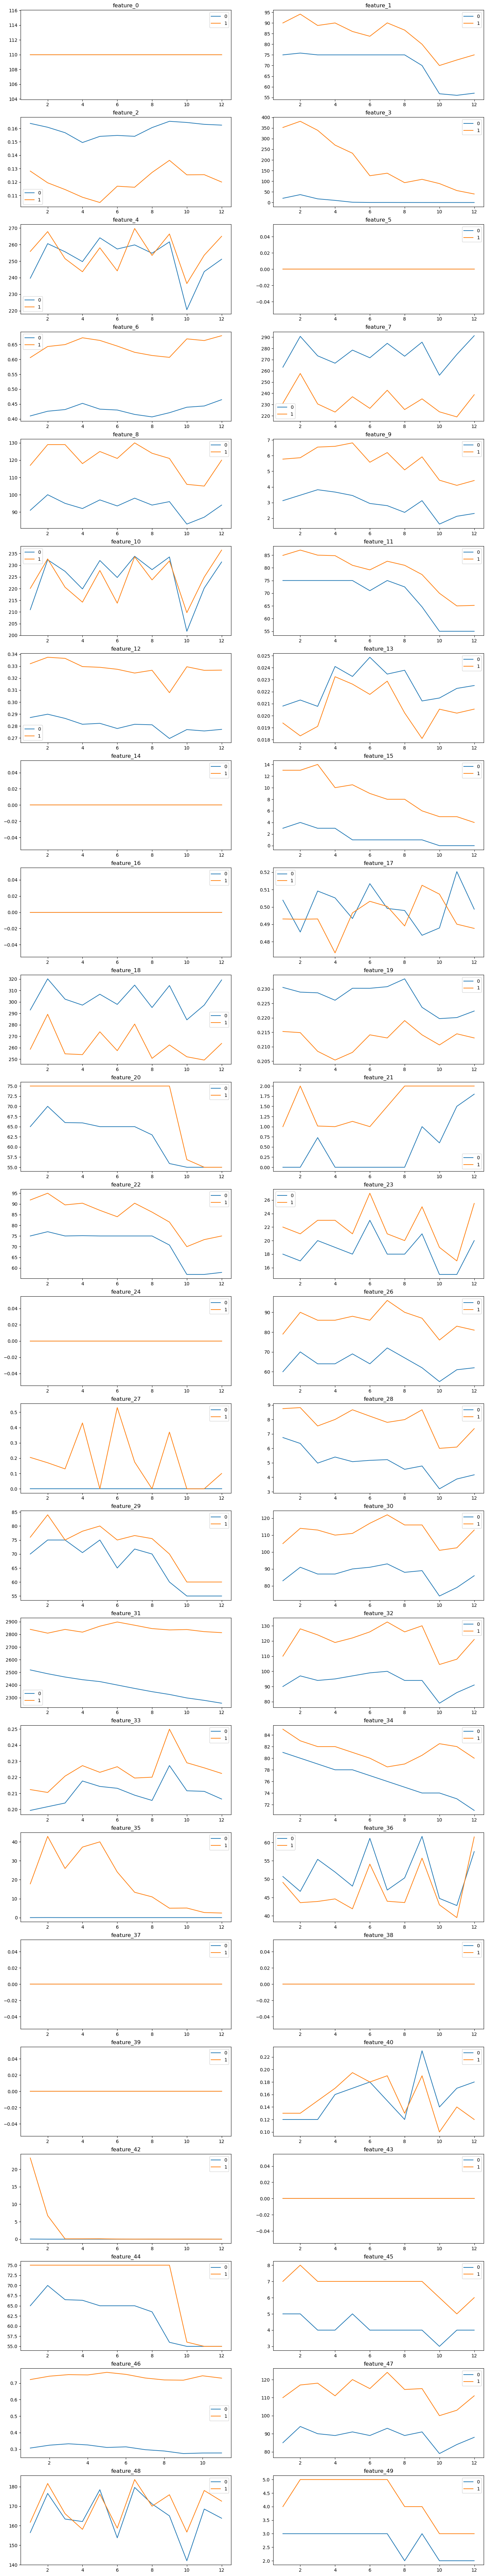

In [1540]:
ax = {}
fig = plt.figure(figsize=(18,100))
for i,j in enumerate(tabular_data.columns[2:]):
    ax[i] = plt.subplot(math.ceil(len(tabular_data.columns[2:])/2),2,i+1)
    temp = tabular_data.merge(train, on='id', how='left').dropna(subset='target').groupby(['target','period'])[j].median().reset_index()
    temp[temp['target']==0].plot(x='period', y=j, ax=ax[i], label='0')
    temp[temp['target']==1].plot(x='period', y=j, ax=ax[i], label='1')
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_title(j)

In [1541]:
# Среднее

tabular_data['feature_0'].value_counts() # видно, что по нему не сработала мединана, надо брать среднее (или дисперсию)
#т.к. доминирует одно значение
# полный список: 
#['feature_0', 'feature_5', 'feature_14', 'feature_16', 'feature_24', 'feature_37', 'feature_38', 'feature_39', 'feature_43']

110.0    56558
111.0      896
114.0      416
112.0      371
113.0      192
119.0       27
Name: feature_0, dtype: int64

In [1542]:
# Тренд

# Разница между значением периода 1 (по факту последнего) и периода 12
# ['feature_3', 'feature_15', 'feature_31', 'feature_42']

In [1543]:
# Дисперсия

# При одном таргете значения фичи резко меняются, а при другом - относительно стабильны
# ['feature_27', 'feature_35', 'feature_38']

In [1544]:
# Медиана
# в итоге пришел к тому, что преобразования надо провести по всем фичам
# это немного улучшает итоговую модель, хотя для больших данных я бы отбирал новые фичи вручную
tabular_data_median = tabular_data.drop(columns='period').groupby('id').median()

In [1545]:
#Среднее
tabular_data_mean = tabular_data.drop(columns='period').groupby('id').mean()

In [1546]:
# Стандартное отклонение
tabular_data_std = tabular_data.drop(columns='period').groupby('id').std() #[['id','feature_27', 'feature_35', 'feature_38']]

In [1547]:
# Тренд
tabular_data_m1 = tabular_data[tabular_data['period']<=5].set_index('id') #[['id','feature_3', 'feature_15', 'feature_31', 'feature_42']]
tabular_data_m12 = tabular_data[tabular_data['period']>=8].set_index('id') #[['id','feature_3', 'feature_15', 'feature_31', 'feature_42']]
tabular_data_m1 = tabular_data_m1.groupby('id').mean() #median()
tabular_data_m12 = tabular_data_m12.groupby('id').mean() #median()
tabular_data_m1_m12 = tabular_data_m1 - tabular_data_m12 

In [1548]:
# проверим, т.к. обработка вышла довольно сложная
tabular_data_m1.loc[1][0] - tabular_data_m12.loc[1][0] == tabular_data_m1_m12.loc[1][0]

True

### Пропущенные значения
У нас есть 2 столбца, которые заполнены для всех записей. Можно предположить, что если остальные колонки не заполнены, то в этом месяце абонент не обслуживался. 

In [1549]:
# поставим 10, т.к. именно с этого значения до 43 значение пропусков практически не меняется
# Думаю, что это истинные месяцы, по которым абоненты не обслуживались
(tabular_data.set_index('id').drop(columns='period').isna().sum(axis=1)>10).sum()

1756

In [1550]:
(tabular_data.set_index('id').drop(columns='period').isna().sum(axis=1)>10).groupby(by='id').sum().value_counts().head()

0     4816
8       46
9       41
10      32
6       27
dtype: int64

### Собираем финальный датасет

In [1553]:
tabular_data_final = tarif.join(tarifs_nmb) #tarifs_nmb 
tabular_data_final = tabular_data_final.join(tabular_data_median, rsuffix='_med') 
tabular_data_final = tabular_data_final.join(tabular_data_mean, rsuffix='_mean') #tabular_data_mean
tabular_data_final = tabular_data_final.join(tabular_data_std, rsuffix='_std')
tabular_data_final = tabular_data_final.join(tabular_data_m1_m12, rsuffix='_1-12')

In [1555]:
# добавляем пропущенные месяцы
tabular_data_final['missing_month'] = (tabular_data.set_index('id').drop(columns='period').isna().sum(axis=1)>10).groupby(by='id').sum()

In [1556]:
hashed_feature_grouped = hashed_feature.groupby('id')['feature_50'].count()

In [1557]:
tabular_data_final = tabular_data_final.join(hashed_feature_grouped)

In [1558]:
tabular_data_final.head(3)

,tarif_390c481a740bb1c12c57f33dc5263ced2ab11796,tarif_aa2c96dacf00c451ef465f6115a45a20bccf1256,tarif_b204e1e3743cc314841070435211e25f4602b9fd,tarif_cf3cca1da7361bd988642600e76c4a3021be8ccf,tarif_cf7413906c99be47067cb3fb6299959857710d77,tarif_d458ece2abeae803254c5d442b2e2a80f58a4153,tarif_f9ae10397ed62e79c644d06842bbcd92963a5927,tarifs_nmb,feature_0,feature_1,...,feature_42_1-12,feature_43_1-12,feature_44_1-12,feature_45_1-12,feature_46_1-12,feature_47_1-12,feature_48_1-12,feature_49_1-12,missing_month,feature_50
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,1,3,110.0,55.0,...,-12.159026,0.0,10.300,0.0,-0.064864,-12.4,-245.918,-0.600000,0,10
1,0,0,0,0,0,0,1,1,110.0,125.0,...,205.268701,-0.2,0.000,-4.4,-0.216367,-88.8,NaN,-487.801914,0,43
2,0,0,1,0,0,0,0,2,110.0,0.0,...,0.000197,0.0,-0.966,0.0,-0.116576,7.6,3.238,0.000000,0,14


In [1559]:
tabular_data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5106 entries, 0 to 5105
Columns: 203 entries, tarif_390c481a740bb1c12c57f33dc5263ced2ab11796 to feature_50
dtypes: float64(193), int64(3), uint8(7)
memory usage: 7.8 MB


В целом, мы имеем неплохой датасет, который практически готов к машинному обучению. Осталось только заполнить Nan.
- Для выборки train мы имеем полной право заполнить Nan по медиане относительно таргета
- Для выборки test мы такой возможности не имеем, попробуем заполнить методом Knn.

In [1561]:
tabular_data_final_train = tabular_data_final.loc[train.index]
tabular_data_final_train_target = tabular_data_final_train.join(train)

In [1563]:
#Для выборки train мы имеем полной право заполнить Nan по медиане относительно таргета
for col in tabular_data_final_train_target.columns:
    tabular_data_final_train_target[col] = \
    tabular_data_final_train_target[col].fillna(tabular_data_final_train_target.groupby('target')[col].transform('median'))
    
tabular_data_final_train_target = tabular_data_final_train_target.drop(columns='target')

In [1565]:
tabular_data_final_train_target.shape

(4084, 203)

## Обучение моделей

In [1564]:
%%time
model = CatBoostClassifier(silent=True)
param_grid={'iterations':[1000]}

grid_CatBoost = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_CatBoost.fit(tabular_data_final_train_target, train)
grid_CatBoost.best_score_
# 0.805
#0.8057
#0.81

CPU times: total: 2min 38s
Wall time: 4min 40s


0.8114340472134027

In [1566]:
pd.DataFrame({'feature':tabular_data_final_train_target.columns, 'est':grid_CatBoost.best_estimator_.feature_importances_}) \
.sort_values(by='est', ascending=False).head(20)

,feature,est
202,feature_50,4.694051
52,feature_46,3.620668
14,feature_6,3.123571
100,feature_46_mean,2.810890
172,feature_19_1-12,2.267585
197,feature_46_1-12,2.181324
62,feature_6_mean,1.757323
166,feature_13_1-12,1.724144
95,feature_40_mean,1.693661
159,feature_6_1-12,1.504869


In [1567]:
%%time
model = lgb.LGBMClassifier(random_state=171022)
param_grid={ 'learning_rate':[0.08, 0.1, 0.12],  #'class_weight':[None, 'balanced'] [0.015, 0.02, 0.03]
             'n_estimators':np.arange(400,610,100),
             'num_leaves':np.arange(2,7,2)
             #'min_data_in_leaf': np.arange(50,105,25 )
}

grid_lgb = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_lgb.fit(tabular_data_final_train_target, train.values.ravel())
grid_lgb.best_score_
#0.792
##0.804 если считать тренд суммируя значения (не медиана), то вылезла новая важная фича feature_3_1-12 и feature_15_1-12
#0.81

CPU times: total: 11.7 s
Wall time: 2min 52s


0.8102156425485607

In [1568]:
pd.DataFrame({'feature':tabular_data_final_train_target.columns, 'est':grid_lgb.best_estimator_.feature_importances_}) \
.sort_values(by='est', ascending=False).head(20)

,feature,est
202,feature_50,71
197,feature_46_1-12,45
159,feature_6_1-12,37
14,feature_6,36
52,feature_46,35
136,feature_33_std,33
172,feature_19_1-12,32
64,feature_8_mean,29
116,feature_12_std,24
95,feature_40_mean,24


### Промежуточные выводы
- Мы достигли Roc-Auc 0.81. Это мало, нам нужно 0.9 и больше.
- Несомненный успех: формирование feature_50, обе модели считают ее очень значимой
- Модели не оценили 'feature_25'. Собственно, это следует из анализа графиков, что значимых различий по таргету не было. Возможно, тут дело в каких-то сочетаниях этих значений, условно, что тот, кто перешел с одного тарифа на другой - владелец автомобиля (было рекламная кампания, направленная на владельцев авто с рекламой определенного тарифа)
- Также не была никак оценена 'feature_17'. В принципе, так и должно было быть согласно предварительному анализу. Можно попробовать развернуть данные этой фичи наподобие временных рядов, т.к. все равно возникает вопрос, зачем в датасет добавили синтетические данные.
- Модели используют все преобразования по числовым признакам в большей или меньшей степени.

## Другие алготитмы создание новые признаков и оценка моделей по ним.

### Сочетания в 'feature_25'

In [1569]:
# у нас уже есть готовая таблица со свеми тарифами, которые были использованы каждым пользователем
feature_25_transformed.head(3)

feature_25,11e623a37e87cf7995c466723ec99688d55cae8c,390c481a740bb1c12c57f33dc5263ced2ab11796,aa2c96dacf00c451ef465f6115a45a20bccf1256,b204e1e3743cc314841070435211e25f4602b9fd,cf3cca1da7361bd988642600e76c4a3021be8ccf,cf7413906c99be47067cb3fb6299959857710d77,d458ece2abeae803254c5d442b2e2a80f58a4153,f9ae10397ed62e79c644d06842bbcd92963a5927
id,,,,,,,,
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [1570]:
feature_25_transformed_combined = feature_25_transformed.copy()
col = feature_25_transformed_combined.columns

for i,j in tqdm(combinations(col,2)):
    feature_25_transformed_combined[i+'_'+j] = feature_25_transformed_combined.apply(lambda x: 1 if x[i]==1 and x[j]==1 else 0, axis=1)

feature_25_transformed_combined = feature_25_transformed_combined.drop(columns=col)

feature_25_transformed_combined_train = feature_25_transformed_combined.loc[train.index]

0it [00:00, ?it/s]

In [1571]:
feature_25_transformed_combined_train.loc[0] #по нулевой записи мы выявили три таких сочетания 
#(3 разных значения можно сочетать тремя разными способами)

feature_25
11e623a37e87cf7995c466723ec99688d55cae8c_390c481a740bb1c12c57f33dc5263ced2ab11796    0
11e623a37e87cf7995c466723ec99688d55cae8c_aa2c96dacf00c451ef465f6115a45a20bccf1256    1
11e623a37e87cf7995c466723ec99688d55cae8c_b204e1e3743cc314841070435211e25f4602b9fd    0
11e623a37e87cf7995c466723ec99688d55cae8c_cf3cca1da7361bd988642600e76c4a3021be8ccf    0
11e623a37e87cf7995c466723ec99688d55cae8c_cf7413906c99be47067cb3fb6299959857710d77    0
11e623a37e87cf7995c466723ec99688d55cae8c_d458ece2abeae803254c5d442b2e2a80f58a4153    0
11e623a37e87cf7995c466723ec99688d55cae8c_f9ae10397ed62e79c644d06842bbcd92963a5927    1
390c481a740bb1c12c57f33dc5263ced2ab11796_aa2c96dacf00c451ef465f6115a45a20bccf1256    0
390c481a740bb1c12c57f33dc5263ced2ab11796_b204e1e3743cc314841070435211e25f4602b9fd    0
390c481a740bb1c12c57f33dc5263ced2ab11796_cf3cca1da7361bd988642600e76c4a3021be8ccf    0
390c481a740bb1c12c57f33dc5263ced2ab11796_cf7413906c99be47067cb3fb6299959857710d77    0
390c481a740bb1c12c57f33dc5263ced

In [1590]:
tabular_data_final_train_target25 = tabular_data_final_train_target.join(feature_25_transformed_combined_train)
# добавили новые фичи

tabular_data_final_train_target25 = tabular_data_final_train_target25.drop(columns=tarif.columns) # уберем старые фичи F25

In [1591]:
%%time
model = lgb.LGBMClassifier(random_state=171022)
param_grid={ 'learning_rate':[0.08, 0.1, 0.12],  #'class_weight':[None, 'balanced'] [0.015, 0.02, 0.03]
             'n_estimators':np.arange(400,610,100),
             'num_leaves':np.arange(2,7,2)
             #'min_data_in_leaf': np.arange(50,105,25 )
}

grid_lgb = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_lgb.fit(tabular_data_final_train_target25, train.values.ravel())
grid_lgb.best_score_


CPU times: total: 13.5 s
Wall time: 3min 6s


0.8120628143559394

In [ ]:
best_col_tabular_data_final_train_target25 = \
pd.DataFrame({'feature':tabular_data_final_train_target25.columns, 'est':grid_lgb.best_estimator_.feature_importances_}) \
.sort_values(by='est', ascending=False).head(50)['feature'].values

In [1595]:
pd.DataFrame({'feature':tabular_data_final_train_target25.columns, 'est':grid_lgb.best_estimator_.feature_importances_}) \
.sort_values(by='est', ascending=False).head(20)

,feature,est
195,feature_50,70
190,feature_46_1-12,41
45,feature_46,36
129,feature_33_std,35
7,feature_6,35
165,feature_19_1-12,32
152,feature_6_1-12,32
57,feature_8_mean,30
117,feature_20_std,27
109,feature_12_std,26


Можно отметить практически незаметный рост Roc-Auc.

### 'feature_25' - направление смены тарифа

In [1576]:
feature_25_text = feature_25.groupby('id')['feature_25'].apply(lambda x: ' '.join(x))

In [1577]:
feature_25_text[0] # т.е. тут мы имеем список тарифов, перечисленных в обратном порядке. 
# С помощью биграмм, для клиента с id=0 мы зафиксируем переход 
# f9ae10397ed62e79c644d06842bbcd92963a5927 11e623a37e87cf7995c466723ec99688d55cae8c
# т.е до тарифа 'f9ae10397ed62e79c644d06842bbcd92963a5927' был тариф '11e623a37e87cf7995c466723ec99688d55cae8c'

'f9ae10397ed62e79c644d06842bbcd92963a5927 f9ae10397ed62e79c644d06842bbcd92963a5927 f9ae10397ed62e79c644d06842bbcd92963a5927 f9ae10397ed62e79c644d06842bbcd92963a5927 11e623a37e87cf7995c466723ec99688d55cae8c 11e623a37e87cf7995c466723ec99688d55cae8c 11e623a37e87cf7995c466723ec99688d55cae8c 11e623a37e87cf7995c466723ec99688d55cae8c 11e623a37e87cf7995c466723ec99688d55cae8c 11e623a37e87cf7995c466723ec99688d55cae8c 11e623a37e87cf7995c466723ec99688d55cae8c aa2c96dacf00c451ef465f6115a45a20bccf1256'

In [1578]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2)) #нам нужны только биграммы
feature_25_text_vectorized = vectorizer.fit_transform(feature_25_text)

In [1579]:
feature_25_text_vectorizedDF = pd.DataFrame(feature_25_text_vectorized.toarray(), columns=vectorizer.get_feature_names_out(), \
             index = feature_25_text.index)

In [1580]:
feature_25_text_vectorizedDF.head(3)

,11e623a37e87cf7995c466723ec99688d55cae8c 11e623a37e87cf7995c466723ec99688d55cae8c,11e623a37e87cf7995c466723ec99688d55cae8c 390c481a740bb1c12c57f33dc5263ced2ab11796,11e623a37e87cf7995c466723ec99688d55cae8c aa2c96dacf00c451ef465f6115a45a20bccf1256,11e623a37e87cf7995c466723ec99688d55cae8c b204e1e3743cc314841070435211e25f4602b9fd,11e623a37e87cf7995c466723ec99688d55cae8c cf3cca1da7361bd988642600e76c4a3021be8ccf,11e623a37e87cf7995c466723ec99688d55cae8c d458ece2abeae803254c5d442b2e2a80f58a4153,11e623a37e87cf7995c466723ec99688d55cae8c f9ae10397ed62e79c644d06842bbcd92963a5927,390c481a740bb1c12c57f33dc5263ced2ab11796 11e623a37e87cf7995c466723ec99688d55cae8c,390c481a740bb1c12c57f33dc5263ced2ab11796 390c481a740bb1c12c57f33dc5263ced2ab11796,390c481a740bb1c12c57f33dc5263ced2ab11796 aa2c96dacf00c451ef465f6115a45a20bccf1256,...,d458ece2abeae803254c5d442b2e2a80f58a4153 d458ece2abeae803254c5d442b2e2a80f58a4153,d458ece2abeae803254c5d442b2e2a80f58a4153 f9ae10397ed62e79c644d06842bbcd92963a5927,f9ae10397ed62e79c644d06842bbcd92963a5927 11e623a37e87cf7995c466723ec99688d55cae8c,f9ae10397ed62e79c644d06842bbcd92963a5927 390c481a740bb1c12c57f33dc5263ced2ab11796,f9ae10397ed62e79c644d06842bbcd92963a5927 aa2c96dacf00c451ef465f6115a45a20bccf1256,f9ae10397ed62e79c644d06842bbcd92963a5927 b204e1e3743cc314841070435211e25f4602b9fd,f9ae10397ed62e79c644d06842bbcd92963a5927 cf3cca1da7361bd988642600e76c4a3021be8ccf,f9ae10397ed62e79c644d06842bbcd92963a5927 cf7413906c99be47067cb3fb6299959857710d77,f9ae10397ed62e79c644d06842bbcd92963a5927 d458ece2abeae803254c5d442b2e2a80f58a4153,f9ae10397ed62e79c644d06842bbcd92963a5927 f9ae10397ed62e79c644d06842bbcd92963a5927
id,,,,,,,,,,,,,,,,,,,,,
0,0.915443,0.0,0.308273,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.165912,0.0,0.0,0.0,0.0,0.0,0.0,0.198505
1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
2,0.000000,0.0,0.000000,0.240599,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [1581]:
feature_25_text_vectorizedDF_train = feature_25_text_vectorizedDF.loc[train.index]

In [1582]:
tabular_data_final_train_target25vect = tabular_data_final_train_target.join(feature_25_text_vectorizedDF_train)
# добавили новые фичи

tabular_data_final_train_target25vect = tabular_data_final_train_target25vect.drop(columns=tarif.columns) # уберем старые фичи F25

In [1583]:
%%time
model = lgb.LGBMClassifier(random_state=171022)
param_grid={ 'learning_rate':[0.08, 0.1, 0.12],  #'class_weight':[None, 'balanced'] [0.015, 0.02, 0.03]
             'n_estimators':np.arange(400,610,100),
             'num_leaves':np.arange(2,7,2)
             #'min_data_in_leaf': np.arange(50,105,25 )
}

grid_lgb = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_lgb.fit(tabular_data_final_train_target25vect, train.values.ravel())
grid_lgb.best_score_


CPU times: total: 10.9 s
Wall time: 2min 10s


0.8097216535378529

In [1584]:
pd.DataFrame({'feature':tabular_data_final_train_target25vect.columns, 'est':grid_lgb.best_estimator_.feature_importances_}) \
.sort_values(by='est', ascending=False).head(20)

,feature,est
195,feature_50,64
190,feature_46_1-12,39
45,feature_46,38
7,feature_6,36
165,feature_19_1-12,34
129,feature_33_std,29
152,feature_6_1-12,27
57,feature_8_mean,26
192,feature_48_1-12,24
93,feature_46_mean,23


К сожалению, предложенные обработки не помогли нам повысить важность 'feature_25'

### Развернем 'feature_17', чтобы использовать все данные в модели (по принципу временных рядов)

In [1585]:
feature_17_pivot = tabular_data.pivot_table(index='id', columns='period', values='feature_17')
feature_17_pivot_train = feature_17_pivot.loc[train.index]

In [1586]:
tabular_data_final_train_target25_17 = tabular_data_final_train_target25.join(feature_17_pivot_train)

In [1587]:
%%time
model = lgb.LGBMClassifier(random_state=171022)
param_grid={ 'learning_rate':[0.08, 0.1, 0.12],  #'class_weight':[None, 'balanced'] [0.015, 0.02, 0.03]
             'n_estimators':np.arange(400,610,100),
             'num_leaves':np.arange(2,7,2)
             #'min_data_in_leaf': np.arange(50,105,25 )
}

grid_lgb = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_lgb.fit(tabular_data_final_train_target25_17, train.values.ravel())
grid_lgb.best_score_

CPU times: total: 13.9 s
Wall time: 3min 19s


0.8112803000209488

In [1588]:
pd.DataFrame({'feature':tabular_data_final_train_target25_17.columns, 'est':grid_lgb.best_estimator_.feature_importances_}) \
.sort_values(by='est', ascending=False).head(20)

,feature,est
195,feature_50,83
45,feature_46,49
190,feature_46_1-12,46
7,feature_6,46
129,feature_33_std,38
165,feature_19_1-12,37
225,2,35
109,feature_12_std,34
98,feature_1_std,33
57,feature_8_mean,32


Можно отметить, что добавление все информации из 'feature_17' никак не улучшило качество нашей модели, хотя некоторые колонки появились в feature_importances_

Попробуем обучить модель на Топ-50 признаков и перебрать гиперпараметры.

In [1596]:
tabular_data_final_train_target25_best = tabular_data_final_train_target25[best_col_tabular_data_final_train_target25]

In [1605]:
%%time
model = lgb.LGBMClassifier(random_state=171022)
param_grid={ 'learning_rate':[0.04, 0.06, 0.08],
             'n_estimators':np.arange(500,710,100),
             'num_leaves':np.arange(2,7,2),
             'min_data_in_leaf': [20,25,30]
}

grid_lgb = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_lgb.fit(tabular_data_final_train_target25_best, train.values.ravel())
grid_lgb.best_score_


CPU times: total: 3.45 s
Wall time: 2min 37s


0.8194481224218344

In [1606]:
grid_lgb.best_params_

{'learning_rate': 0.06,
 'min_data_in_leaf': 20,
 'n_estimators': 500,
 'num_leaves': 4}

## Выводы
- После произведенных преобразований с вышеуказанной логикой можно получить Roc-Auc 0.82
- Проверку на выборке 'test' не производил, т.к. на данный момент это не имеет смысла, Roc-Auc больше 0.9 мы не получим. Да и обычно оценка на тесте практически не отличается от кросс-валидации.

 Ссылка на оригинальное решение https://www.youtube.com/watch?v=jOQefsrEvhg&list=PLQJ7ptkRY-xbefSg1XN3FA-SdSRFcCQfn&index=3